# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

## Imports and Setup  

In [1]:
import os
import shutil
import subprocess
import zipfile

!wget -q -O utils.py https://raw.githubusercontent.com/gtadams/2155-CP3-GTA/main/utils.py
!wget -q -O evaluate.py https://raw.githubusercontent.com/gtadams/2155-CP3-GTA/main/evaluate.py
import urllib.request

repo_url = "https://github.com/gtadams/2155-CP3-GTA.git"
zip_url = "https://github.com/gtadams/2155-CP3-GTA/archive/refs/heads/main.zip"
target_dir = "dataset"

if not os.path.isdir(target_dir):
    print("Dataset folder not found, attempting to obtain it from the repository...")

    # 1) Try a shallow git clone
    try:
        subprocess.run(["git", "clone", "--depth", "1", repo_url], check=True, stdout=subprocess.DEVNULL)
        repo_folder = "2155-CP3-GTA"
        repo_dataset = os.path.join(repo_folder, "dataset")
        if os.path.isdir(repo_dataset):
            if os.path.isdir(target_dir):
                shutil.rmtree(target_dir)
            shutil.move(repo_dataset, target_dir)
            shutil.rmtree(repo_folder)
            print(f"✓ Dataset moved to ./{target_dir}")
        else:
            # fallback to zip download if dataset folder not present
            raise FileNotFoundError("dataset folder not present in cloned repo")
    except Exception as e_git:
        print("git clone failed or dataset not present, trying zip download...", str(e_git))
        try:
            zip_path = "repo_main.zip"
            urllib.request.urlretrieve(zip_url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as z:
                z.extractall()
            # find extracted folder
            extracted_dirs = [d for d in os.listdir() if d.startswith("2155-CP3-GTA") and os.path.isdir(d)]
            if extracted_dirs:
                extracted = extracted_dirs[0]
                extracted_dataset = os.path.join(extracted, "dataset")
                if os.path.isdir(extracted_dataset):
                    if os.path.isdir(target_dir):
                        shutil.rmtree(target_dir)
                    shutil.move(extracted_dataset, target_dir)
                    shutil.rmtree(extracted)
                    os.remove(zip_path)
                    print(f"✓ Dataset extracted to ./{target_dir}")
                else:
                    raise FileNotFoundError("dataset folder not found inside zip")
            else:
                raise FileNotFoundError("expected extracted repo folder not found")
        except Exception as e_zip:
            print("Failed to obtain dataset automatically:", e_zip)
            print("Please download the 'dataset' folder into the notebook working directory manually.")
else:
    print(f"Dataset already present at ./{target_dir}")

Dataset folder not found, attempting to obtain it from the repository...
✓ Dataset moved to ./dataset


In [2]:
from utils import *
from evaluate import *

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()

Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)


In [4]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [5]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 21.7%


## VAE Model Architecture

In [6]:
# VAE Model Architecture for Missing Value Imputation
class VAE(nn.Module):
    """
    Variational Autoencoder designed for missing value imputation.

    Key features:
    - Handles arbitrary missing patterns through masking
    - Learns feature dependencies in latent space
    - Generates probabilistic imputations
    - Uses residual connections and dropout for robustness
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64],
                 use_residual=True, dropout_rate=0.3):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.use_residual = use_residual
        self.hidden_dims = hidden_dims

        # Feature importance network (learns which features are important for each position)
        self.feature_importance = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dims[0] // 2),  # input + mask
            nn.ReLU(),
            nn.Linear(hidden_dims[0] // 2, input_dim),
            nn.Sigmoid()
        )

        # Encoder with residual connections
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # input + mask

        for i, hidden_dim in enumerate(hidden_dims):
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Initialize latent layers with smaller weights for stability
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)  # Start with low variance

        # Decoder with skip connections
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim + input_dim  # latent + observed + positional encoding

        reversed_dims = list(reversed(hidden_dims))
        for i, hidden_dim in enumerate(reversed_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Final output layer
        self.output_layer = nn.Linear(hidden_dims[0], input_dim)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        """Encode input with missing value masking."""
        # Calculate feature importance weights
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)
        importance_weights = self.feature_importance(encoder_input)

        # Apply importance weighting to the input
        weighted_input = x * mask_float * importance_weights
        encoder_input = torch.cat([weighted_input, mask_float], dim=1)

        # Pass through encoder layers with residual connections
        h = encoder_input
        skip_connections = []

        for i, layer in enumerate(self.encoder_layers):
            prev_h = h
            h = layer(h)

            # Add residual connection for deeper layers
            if self.use_residual and i > 0 and h.shape == prev_h.shape:
                h = h + prev_h

            skip_connections.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Clamp logvar to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar, skip_connections

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        """Decode latent representation conditioned on observed values."""
        # Enhanced conditioning on observed values
        mask_float = mask.float()
        x_masked = x_observed * mask_float

        # Add positional encoding for better feature understanding
        pos_encoding = torch.arange(self.input_dim, dtype=torch.float32, device=z.device)
        pos_encoding = pos_encoding.unsqueeze(0).expand(z.size(0), -1) / self.input_dim

        # Concatenate latent code with observed values and positional encoding
        decoder_input = torch.cat([z, x_masked, pos_encoding], dim=1)

        # Pass through decoder layers
        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        # Get reconstruction
        reconstruction = self.output_layer(h)

        return reconstruction

    def forward(self, x, mask):
        """Forward pass through VAE."""
        mu, logvar, _ = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)

        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        """Generate multiple imputation samples for missing values."""
        self.eval()

        with torch.no_grad():
            # Get multiple samples from the posterior
            mu, logvar, _ = self.encode(x_incomplete, mask)

            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)

                # Combine observed values with imputed values
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())

            samples = np.stack(samples, axis=1)  # Shape: (batch_size, n_samples, n_features)

        return samples

In [7]:
# Loss Functions and Training Utilities

def loss_function(recon_x, x, mu, logvar, mask, beta=1.0):
    """
    Enhanced VAE loss function with missing value handling.

    Args:
        recon_x: Reconstructed data
        x: Original data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        mask: Binary mask (1 for observed, 0 for missing)
        beta: Weight for KL divergence term
    """
    # Reconstruction loss only on observed values
    reconstruction_diff = (recon_x - x) ** 2

    # Only consider observed values and normalize properly
    masked_loss = reconstruction_diff * mask
    recon_loss = masked_loss.sum() / (mask.sum() + 1e-8)

    # Add standard MSE loss for stability
    standard_recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='mean')
    recon_loss = 0.7 * recon_loss + 0.3 * standard_recon_loss

    # KL divergence with free bits to prevent posterior collapse
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # Normalize by batch size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def get_beta_schedule(epoch, total_epochs, schedule_type='cosine'):
    """Get beta value for KL annealing schedule."""
    if schedule_type == 'linear':
        return min(1.0, epoch / (total_epochs * 0.5))
    elif schedule_type == 'sigmoid':
        return 1.0 / (1.0 + np.exp(-(epoch - total_epochs * 0.5) / (total_epochs * 0.1)))
    elif schedule_type == 'cosine':
        return 0.5 * (1 + np.cos(np.pi * (1 - epoch / total_epochs)))
    elif schedule_type == 'constant':
        return 1.0
    else:
        return 1.0


def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Get model predictions
            reconstruction, mu, logvar = model(batch_data, batch_mask)

            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

## Model Initialization and Training

### Model Training Process

This section implements the complete training pipeline with several important features:

**Training Configuration:**
- **Latent Dimension**: 128 (balance between expressiveness and computational efficiency)
- **Architecture**: Deep encoder/decoder with residual connections
- **Regularization**: Dropout and batch normalization for stability
- **Optimization**: AdamW with cosine annealing for smooth convergence

**Advanced Training Features:**
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Gradient Clipping**: Ensures stable training by preventing exploding gradients  
- **Beta Scheduling**: Gradual KL annealing for better latent space learning
- **Learning Rate Scheduling**: Cosine annealing with warm restarts

The training loop tracks multiple loss components to monitor model health and convergence.

In [ ]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, channels=(64,128,256), out_channels=1):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev = in_channels
        # down blocks
        for ch in channels:
            self.downs.append(nn.Sequential(
                nn.Conv1d(prev, ch, kernel_size=3, padding=1),
                nn.BatchNorm1d(ch),
                nn.ReLU(),
                nn.Conv1d(ch, ch, kernel_size=3, padding=1),
                nn.BatchNorm1d(ch),
                nn.ReLU()
            ))
            prev = ch
        # up blocks (simple nearest upsample + conv)
        for ch in reversed(channels):
            self.ups.append(nn.Sequential(
                nn.Conv1d(prev, ch, kernel_size=3, padding=1),
                nn.BatchNorm1d(ch),
                nn.ReLU()
            ))
            prev = ch
        self.final = nn.Conv1d(prev, out_channels, kernel_size=1)

        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        skips = []
        h = x
        # encoder
        for down in self.downs:
            h = down(h)
            skips.append(h)
            h = self.pool(h)
        # bottleneck stays as is
        # decoder (upsample + add skip)
        for up, skip in zip(self.ups, reversed(skips)):
            h = nn.functional.interpolate(h, scale_factor=2, mode='nearest')
            # crop/align if needed
            if h.size(-1) != skip.size(-1):
                h = nn.functional.pad(h, (0, skip.size(-1) - h.size(-1)))
            h = torch.cat([h, skip], dim=1) if h.size(1)==skip.size(1) else h
            h = up(h)
        out = self.final(h)
        return out


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 128
  - hidden_dims: [512, 256, 128]
  - use_residual: True
  - dropout_rate: 0.3
  - learning_rate: 0.001
  - num_epochs: 20
  - beta_initial: 1.0
  - beta_schedule: cosine
  - patience: 15

Initializing Diffusion model...
✓ Model initialized with 56,572,289 parameters
✓ Optimizer and scheduler initialized

Starting training for 20 epochs...


Epoch 1/5: 100%|██████████| 47/47 [00:22<00:00,  2.12it/s, loss=0.048751]


Epoch 1/5 - Average Loss: 0.152519


Epoch 2/5: 100%|██████████| 47/47 [00:20<00:00,  2.32it/s, loss=0.010911]


Epoch 2/5 - Average Loss: 0.023668


Epoch 3/5: 100%|██████████| 47/47 [00:20<00:00,  2.30it/s, loss=0.003337]


Epoch 3/5 - Average Loss: 0.006168


Epoch 4/5: 100%|██████████| 47/47 [00:20<00:00,  2.28it/s, loss=0.002696]


Epoch 4/5 - Average Loss: 0.003041


Epoch 5/5: 100%|██████████| 47/47 [00:20<00:00,  2.27it/s, loss=0.002237]


Epoch 5/5 - Average Loss: 0.002617

✓ Training completed!
  - Total training steps recorded: 235
  - Final recorded loss: 0.002237
✓ Best model loaded


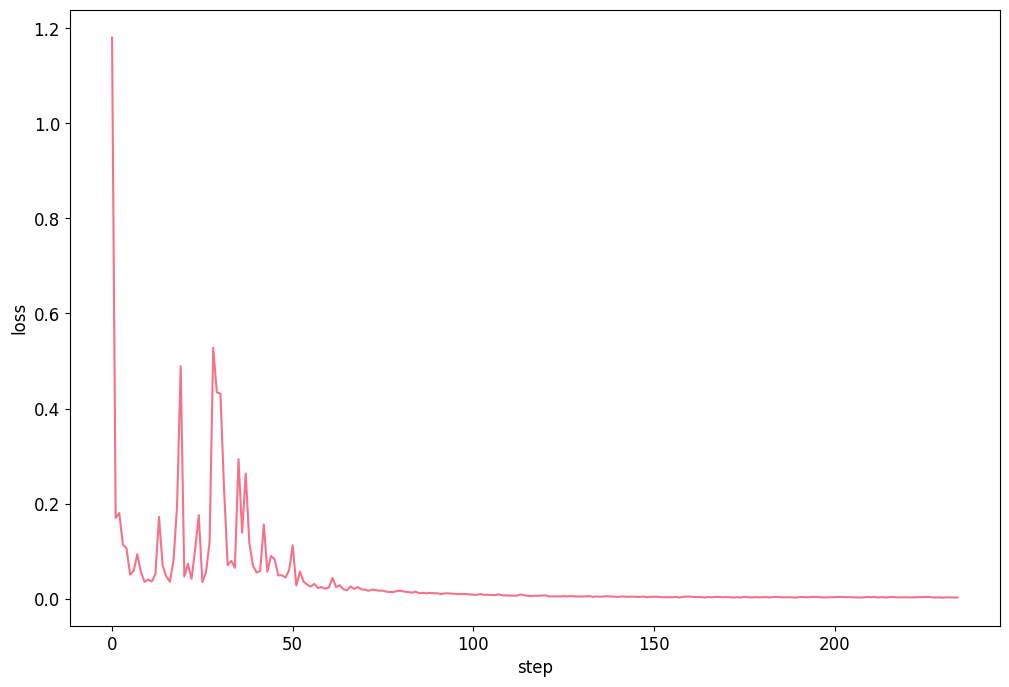

In [ ]:
from diffusers import DDPMScheduler

print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration
config = {
    'input_dim': len(feature_names),
    'latent_dim': 128,
    'hidden_dims': [512, 256, 128],
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'num_epochs': 20,
    'beta_initial': 1.0,
    'beta_schedule': 'cosine',
    'patience': 15
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# Initialize the model
print(f"\nInitializing Diffusion model...")
model = UNet1D(in_channels=1, base_channels=64, channels=(64,128,256), out_channels=1).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000, # number of noising steps during training
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear")

print(f"✓ Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
def compute_loss(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)


print(f'\n✓ Training completed!')
# Avoid indexing empty lists in prints; print summary from `losses`
print(f'  - Total training steps recorded: {len(losses)}')
if losses:
    print(f'  - Final recorded loss: {losses[-1]:.6f}')
torch.save(model.state_dict(), 'best_model.pth') # TODO in the right place?

plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f'✓ Best model loaded')

## Model Evaluation and Metrics


In [9]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...


RuntimeError: The size of tensor a (37) must match the size of tensor b (64) at non-singleton dimension 1

### Model Evaluation and Comprehensive Metrics

This section evaluates our trained VAE on the test set using multiple complementary metrics. Since we're dealing with missing value imputation, we only evaluate the model's predictions on positions that were originally missing.

**Key Evaluation Metrics:**

**1. Mean Squared Error (MSE)**:
- Measures average squared difference between predicted and true values
- Lower is better; sensitive to outliers
- Good for understanding magnitude of errors

**2. Correlation Coefficient**:
- Measures linear relationship strength between predictions and dataset
- Range: [-1, 1], closer to 1 is better
- Shows if model captures feature relationships

**3. Jensen-Shannon (JS) Divergence**:
- Measures difference between predicted and true value distributions
- Range: [0, 1], closer to 0 is better
- Captures whether model preserves the overall data distribution

**4. Maximum Mean Discrepancy (MMD)**:
- Measures distributional difference using kernel methods (RBF kernel)
- Range: [0, ∞], closer to 0 is better
- Non-parametric test for comparing distributions

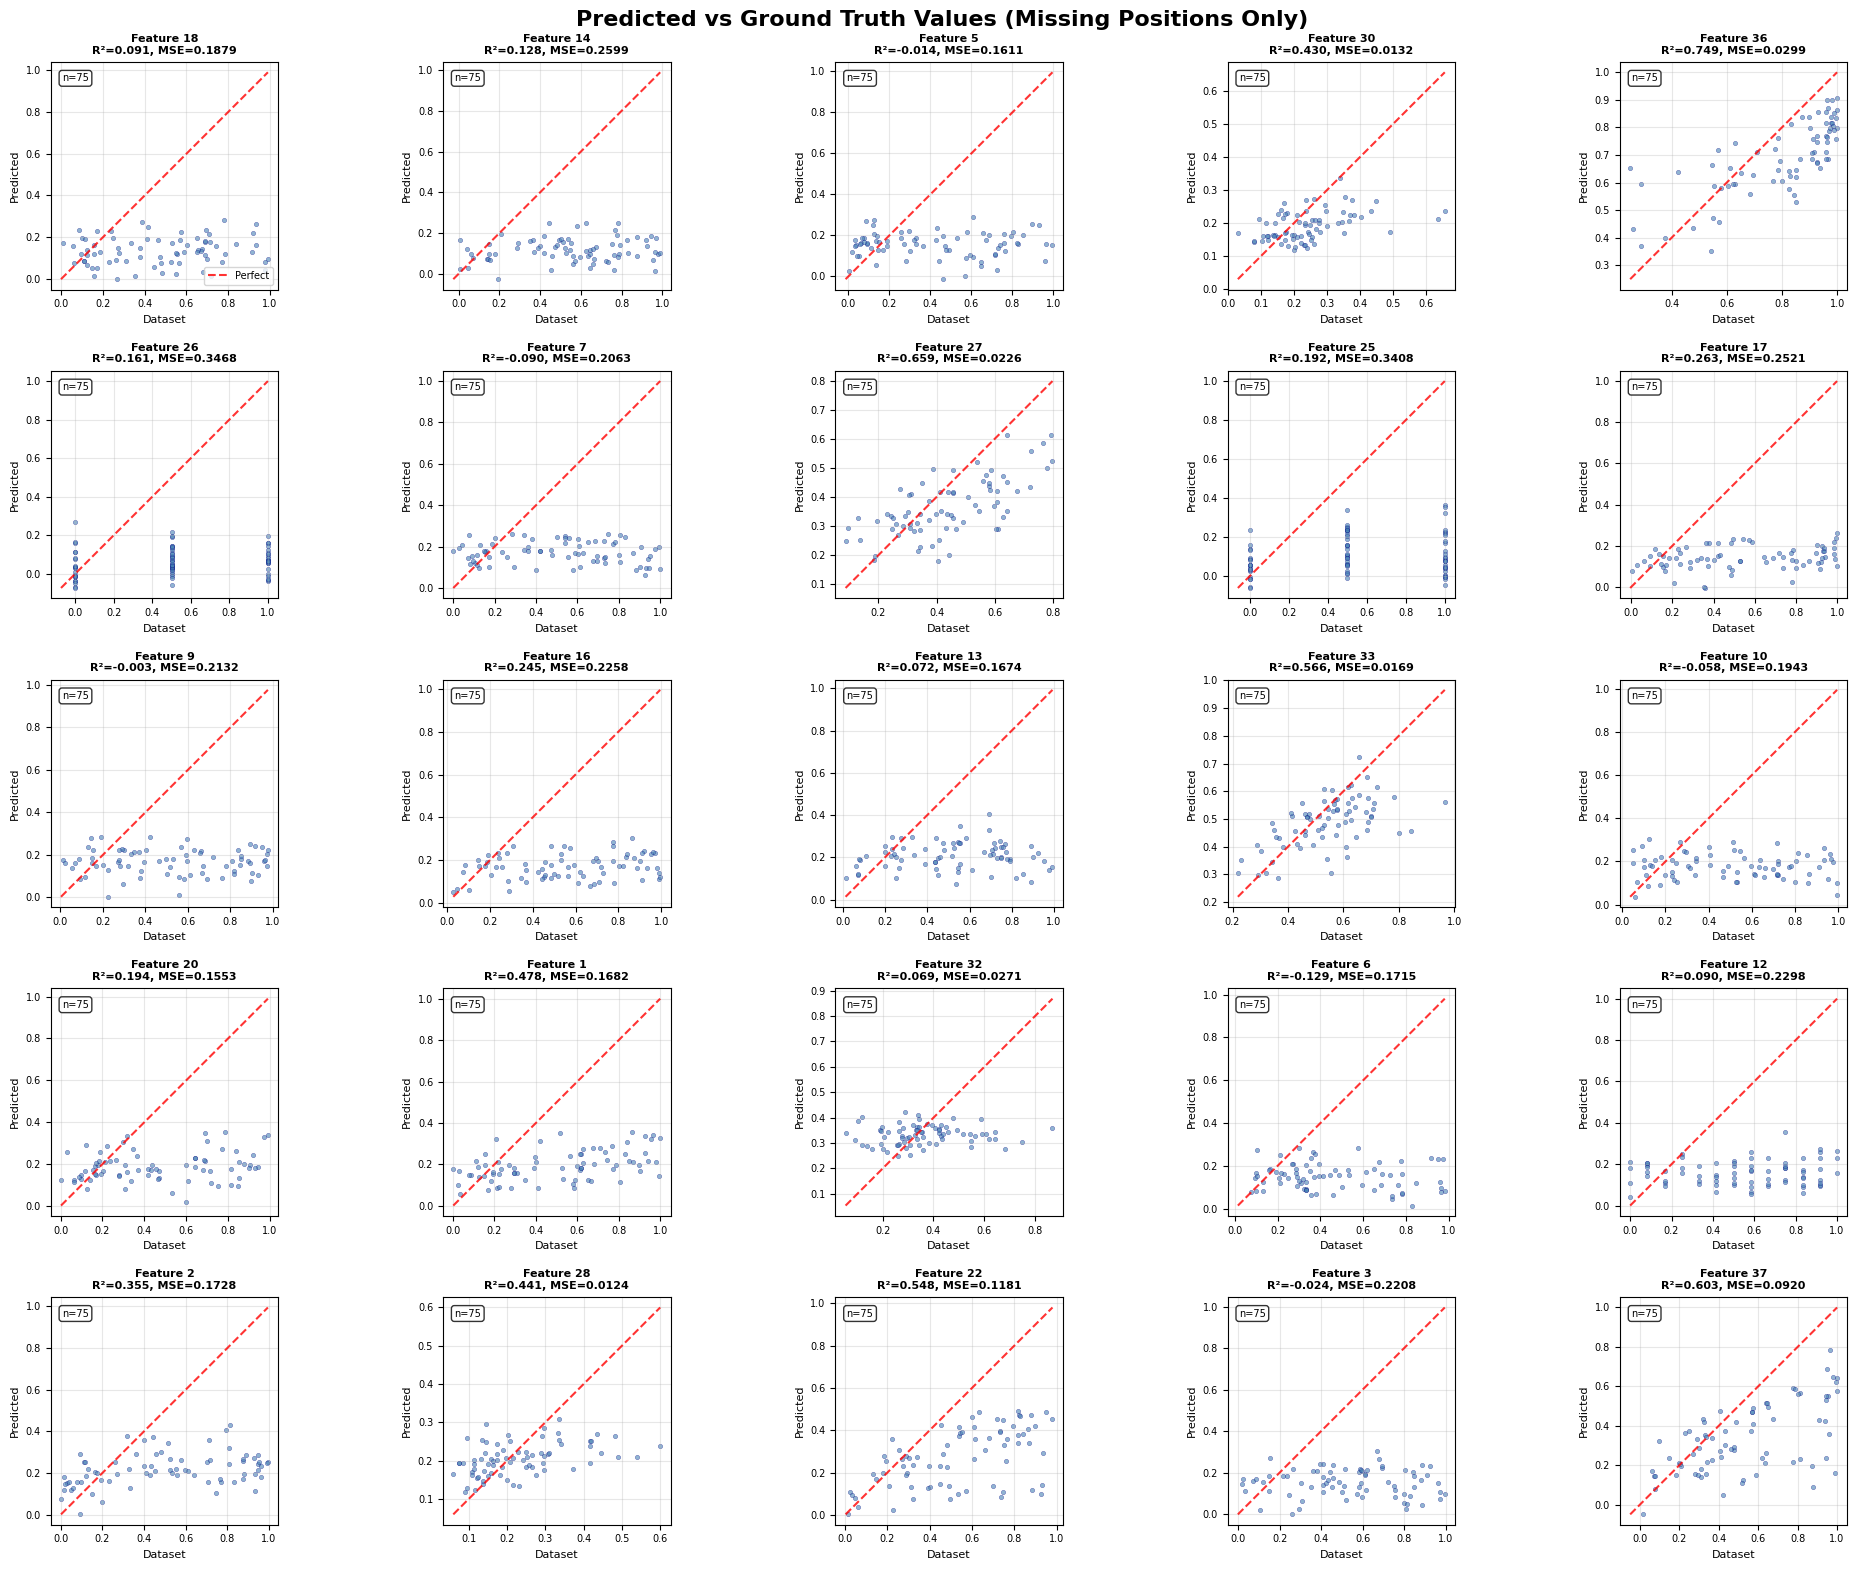

In [ ]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=25)



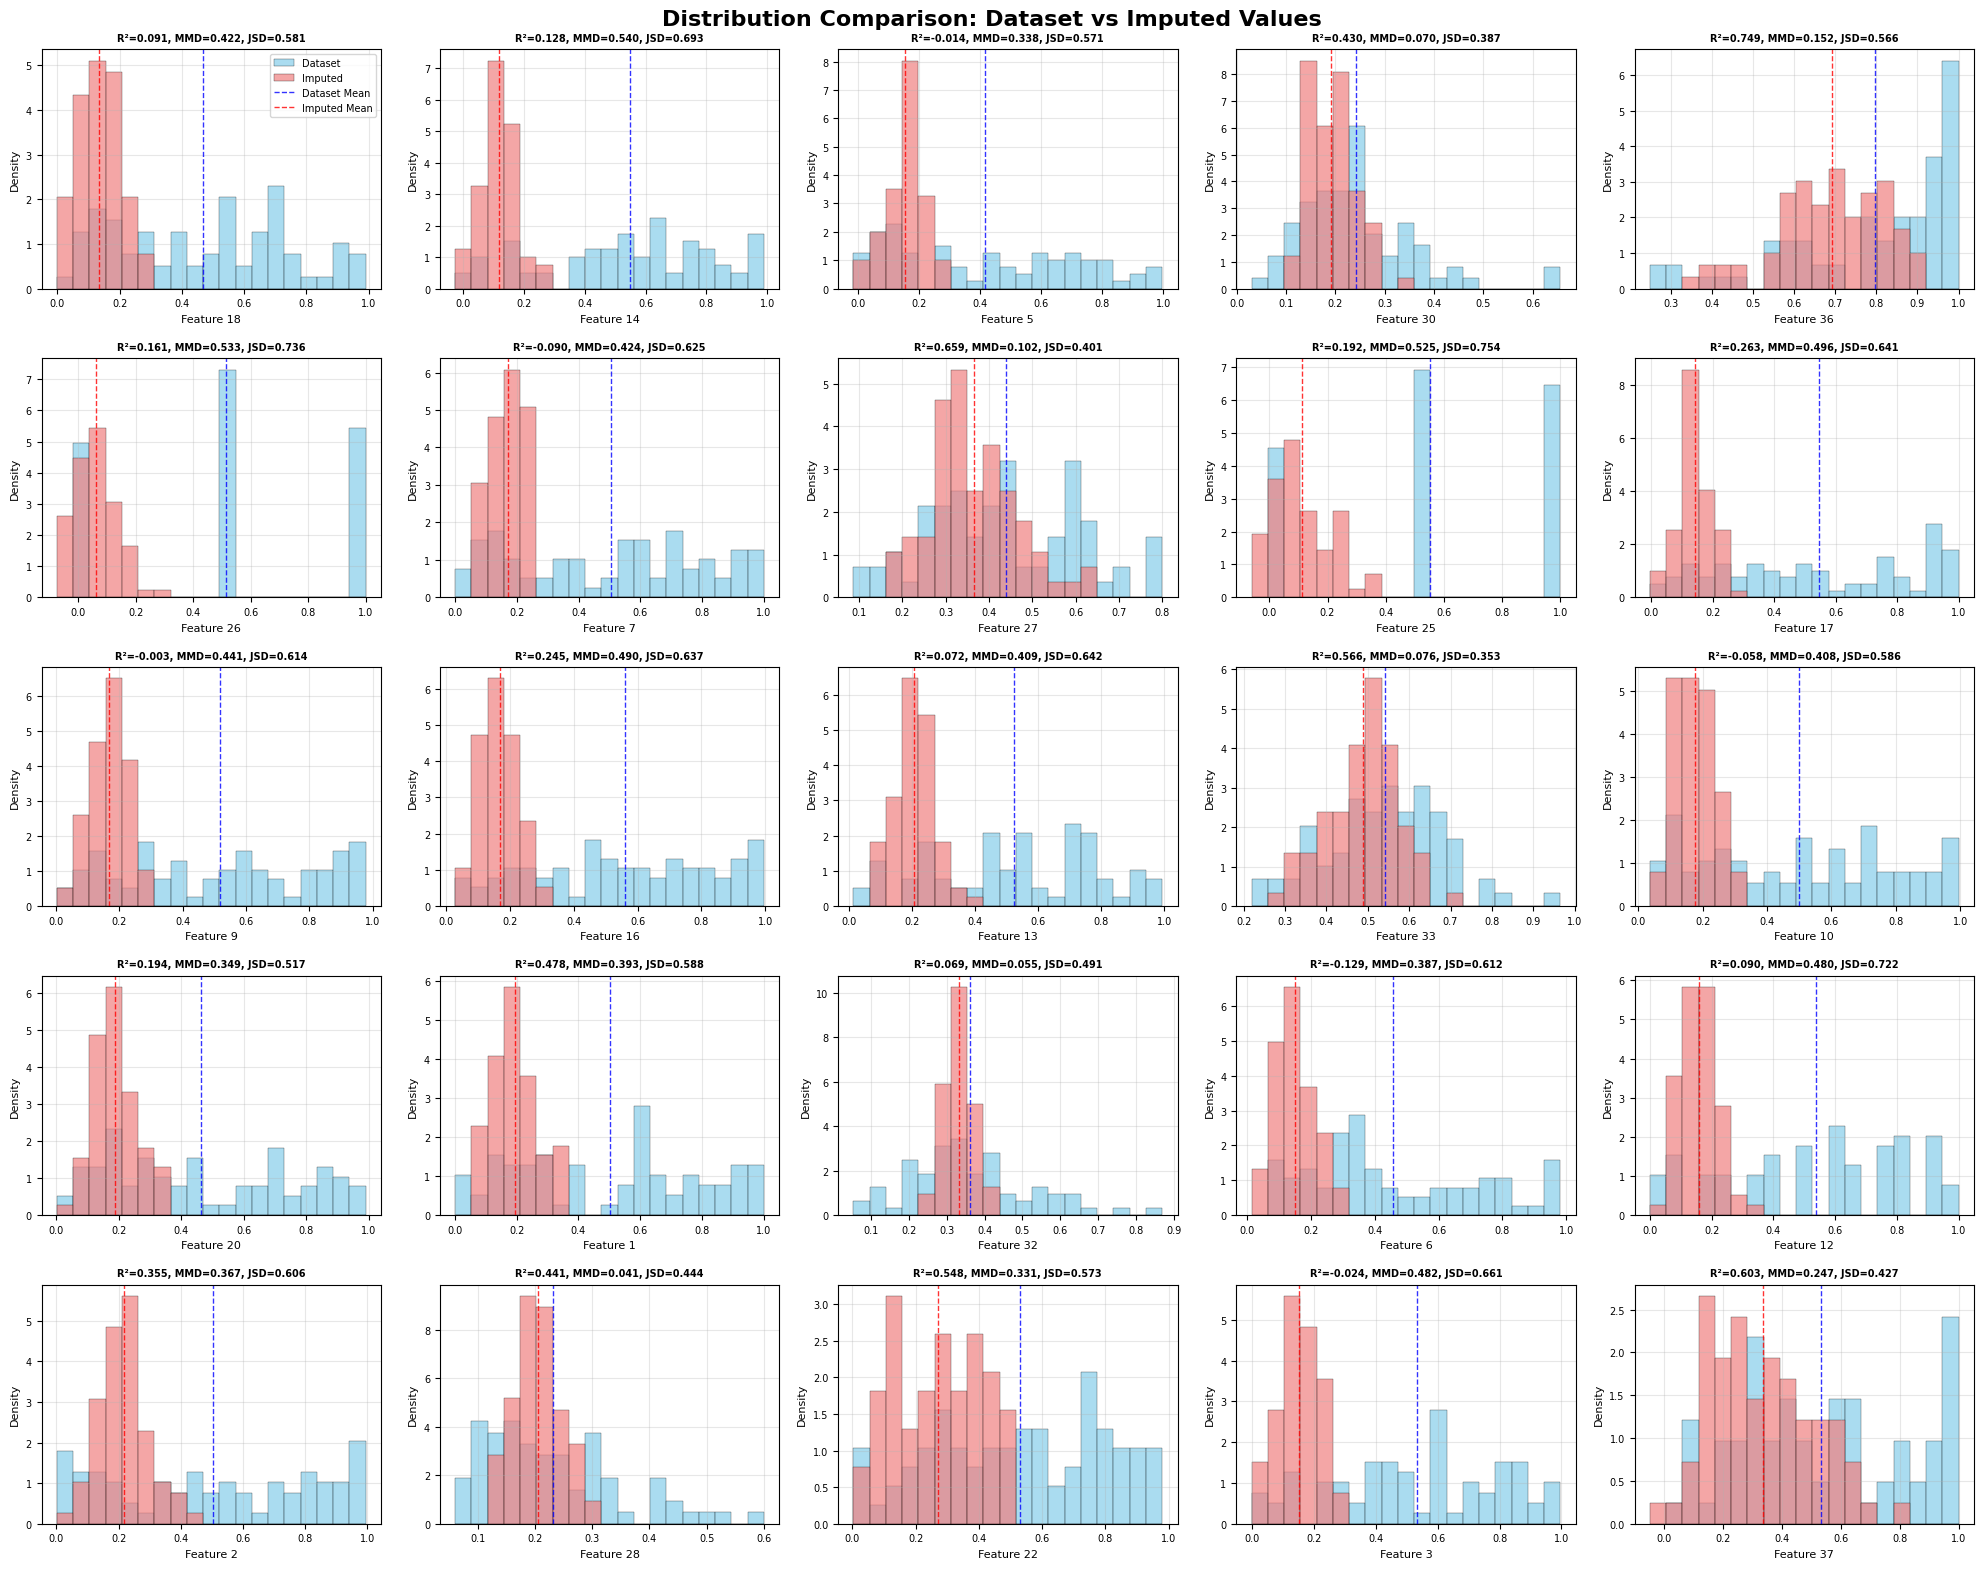

In [ ]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


### Distribution Comparison Visualizations

Visual comparison of predicted vs. dataset distributions is crucial for understanding model performance beyond simple error metrics. These plots help us assess:

**What the Plots Show:**
- **Red (Imputed)**: Distribution of model's predicted values for missing positions
- **Blue (Dataset)**: Distribution of actual values at those same positions
- **Overlap**: How well the model captures the true data distribution

**Why This Matters:**
- A good generative model should not just minimize error, but also preserve the statistical properties of the data
- If distributions match well, the model is generating realistic values
- Large differences indicate the model may be systematically biased or missing important patterns

**Interpretation:**
- **Good**: Overlapping distributions with similar shapes and centers
- **Concerning**: Shifted means, different variances, or completely different shapes

In [ ]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [ ]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:00<00:00, 15.26it/s]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0753, 1.0000]


In [ ]:
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1529
MAE          : 0.2963
Correlation  : 0.229
JS Divergence: 0.1824

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.1667     0.3320     0.462    0.3672   75      
1        0.1733     0.3309     0.369    0.4217   75      
2        0.2194     0.3976     -0.036   0.4880   75      
3        0.2147     0.3890     -0.078   0.4315   75      
4        0.1619     0.3173     -0.021   0.3387   75      
5        0.1692     0.3194     -0.083   0.4204   75      
6        0.2065     0.3650     -0.088   0.3991   75      
7        0.1628     0.3254     -0.114   0.4096   75      
8        0.2143     0.3808     -0.022   0.3840   75      
9        0.1886     0.3501     0.057    0.4076   75      
10       0.1809     0.3442     0.016    0.3773   75  

The final score is computed as: Mean Correlation − Mean JS Divergence − Mean MSE

Just as we compare generated samples for the test set against the original unimputed values, we will apply the same metric to the samples you generate for test2, using the hidden test2 set. This will determine your final submission score.

## Preparing a submission:
Let's prepare a submission. We expect the final submission to be a 417x100x37 numpy array. These correspond to the 100 diverse samples you generated based on the constrained parameters we provided in the test2 set.

In [ ]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:00<00:00, 15.48it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0731, 1.0000]


### Test2 Evaluation: Generating Diverse Design Completions

This is the core evaluation for your AI Copilot assignment. Here we:

**Input**: Test2 samples with some known features (constraints) and some missing features (free parameters)

**Output**: 100 diverse, plausible completions for each test sample

**Why 100 Samples?**
- Engineers want to explore multiple design options, not just one "best" solution
- Diversity helps discover unexpected but valid design combinations  

**Technical Process:**
1. For each test2 sample, use the trained model to generate 100 different completions
2. Each completion respects the known constraints (observed values)
3. Missing values are filled with diverse, model-generated predictions
4. Final output: 417 × 100 × 37 array (417 test samples, 100 variants each, 37 features)

In [ ]:
id = np.random.randint(1e8, 1e9-1)
# np.save(f"{id}.npy", test2_samples)
np.save("GTA_cp3_submission.npy", test2_samples)

### Summary and Tips for CP3

The VAE baseline reproduces the dataset distribution well for some features, but others still show substantial discrepancies, indicating significant room for improvement!

**Key Observations:**
- **Strengths**: The model captures general feature ranges and some distributional patterns
- **Weaknesses**: Some features show systematic bias or poor distribution matching
- **Opportunities**: Advanced architectures (diffusion models, transformers) or better conditioning strategies could improve performance

**For Your Assignment**: Consider these results as a baseline. Think about:
- Which features are hardest to predict and why?
- How could you modify the architecture or training process?
- What additional constraints or domain knowledge could help?